In [2]:
#from utils import load_data, MidpointNormalize, equipotential_standard_normal, plot_heatmaps
import sys
wd = '/ceph/ibmi/it/users/zabel/tsne/diss'
sys.path.insert(0, wd)

import pandas as pd
#import seaborn as sns

from tsne_jax import *

from utils import *
import matplotlib.pyplot as plt
#import tikzplotlib
import jax

from tueplots import cycler, fonts, fontsizes, bundles
from tueplots.constants import markers
from tueplots.constants.color import palettes

import scipy

plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
#plt.rcParams.update(fonts.aistats2022_tex(family="serif"))
#plt.rcParams.update(fontsizes.aistats2022())
#plt.rcParams['axes.grid'] = False


In [3]:
def plot_matrix(M):
  for i, row in enumerate(M):
    s = ''
    for j, col in enumerate(row):
      s = s +'('+str(j)+','+str(i)+') ['+str(M[i, j])+'] '
    print(s)
    print('\n')

### Load matrices generated in R

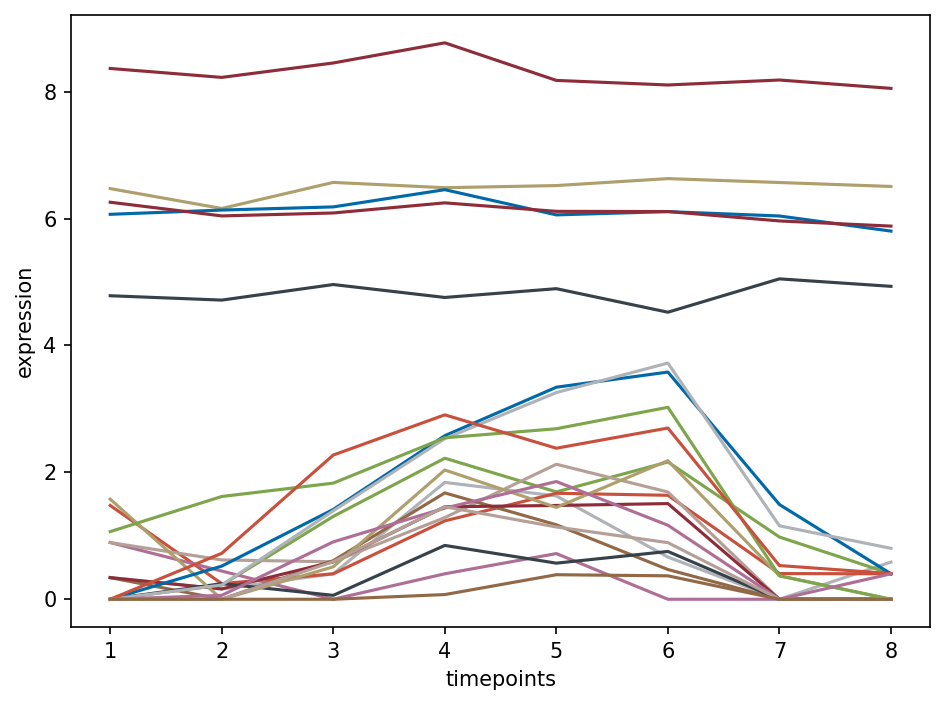

In [29]:
X = pd.read_csv('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/M1152-F519-521_quantnorm.tsv', header=0, sep='\t', index_col=0)
X = X.transpose()
X = X.drop(['F519_69h', 'F521_69h', 'F522_69h'])
#print(X.head(24))


# Step 1: Group every 3 rows (replicates) together
replicate_groups = [0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4, 5, 6, 7]  # 8 groups of 3 replicates each

# Step 2: Compute mean per group
df_mean = X.groupby(replicate_groups).mean()
f = plt.figure()
for i in ['SCO'+str(i) for i in range(5070, 5091)]:
  plt.plot(np.arange(1,9), df_mean[i])
  plt.xlabel('timepoints')
  plt.ylabel('expression')
  plt.tight_layout()

# Step 3: Compute variance within each group of 3 replicates
# This results in a numpy array of shape (8, number of columns)
df_vars = X.groupby(replicate_groups).var()

# Set the top x% threshold (e.g., top 50%)
top_percent = 5

# Calculate variance for each column
variances = df_mean.var()

# Determine the cutoff variance value
cutoff = variances.quantile(1 - top_percent / 100)

# Filter columns with variance in the top x%
X = df_mean.loc[:, variances >= cutoff]

df_vars = df_vars.loc[:, variances >=cutoff]
flatten_vars, _ = flatten_util.ravel_pytree(df_vars.values)

#N = np.identity(X.values.shape[0])
input_cov = flatten_vars


Note that the selected top 5 % most variant genes in M1152 may be different compared to M145

In [5]:
print(X.shape)

(8, 396)


In [6]:
labels_unique = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8']
labels = labels_unique
#labels = ['t1', 't1', 't1','t2', 't2', 't2', 't3', 't3', 't3', 't4', 't4', 't4', 't5', 't5', 't5', 't6', 't6', 't6', 't7', 't7', 't7', 't8', 't8', 't8']

In [7]:
from openTSNE import TSNE
#X = scipy.stats.matrix_normal.rvs(mean, cov1, cov2)
X_array = X.values

#X, y = load_data(10)
key = random.PRNGKey(69)

y_guess = random.normal(key, shape=(X_array.shape[0], 2))
#
Y_star = tsne_fwd(X_array, y_guess)
#tsne = TSNE(verbose=True, random_state=42)
#Y_star = tsne.fit(X_array,)

X_flat, X_unflattener = flatten_util.ravel_pytree(np.array(X_array))   # row-wise
Y_flat, Y_unflattener = flatten_util.ravel_pytree(Y_star)

np.save('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/tsne_embedding_M1152.npy', Y_star)


Perplexity value 30 is too high. Using perplexity 2.33 instead


===> Finding 7 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 0.00 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=0.67 for 250 iterations...
Iteration   50, KL divergence 0.4072, 50 iterations in 0.2598 sec
Iteration  100, KL divergence 0.3793, 50 iterations in 0.2433 sec
Iteration  150, KL divergence 0.3740, 50 iterations in 0.2409 sec
Iteration  200, KL divergence 0.3737, 50 iterations in 0.2426 sec
Iteration  250, KL divergence 0.3737, 50 iterations in 0.2430 sec
   --> Time elapsed: 1.23 seconds
===> Running optimization with exaggeration=1.00, lr=8.00 for 750 iterations...
Iteration   50, KL divergence 0.0246, 50 iterations in 0.2423 sec
Iteration  100, KL divergence 0.0172, 50 iterations in 0.2417 sec
Iteration  150, KL divergence 0.0139, 50 iterations in 0.2443 sec
Iteration  200, KL divergence 0.0125, 50 iterations in 0.2425 sec
Iteration  250,

In [8]:
KL_divergence_dy(X_flat, Y_flat, X_unflattener, Y_unflattener, perplexity=2.33)

Array([-6.0470583e-04,  9.3869347e-04, -1.5066391e-03, -6.3624955e-04,
        2.0594136e-03, -3.9747325e-04,  1.0112186e-03,  2.4162910e-04,
       -5.5245333e-04, -1.4404018e-04,  1.1474581e-03,  2.6184146e-04,
        5.7662569e-04, -2.9672973e-04, -2.1309105e-03,  3.2330405e-05],      dtype=float32)

/tmp/ipykernel_4048165/3253612423.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatter = plt.scatter(Y_star[inds, 0], Y_star[inds, 1], c = color_mapping[i], label=i)


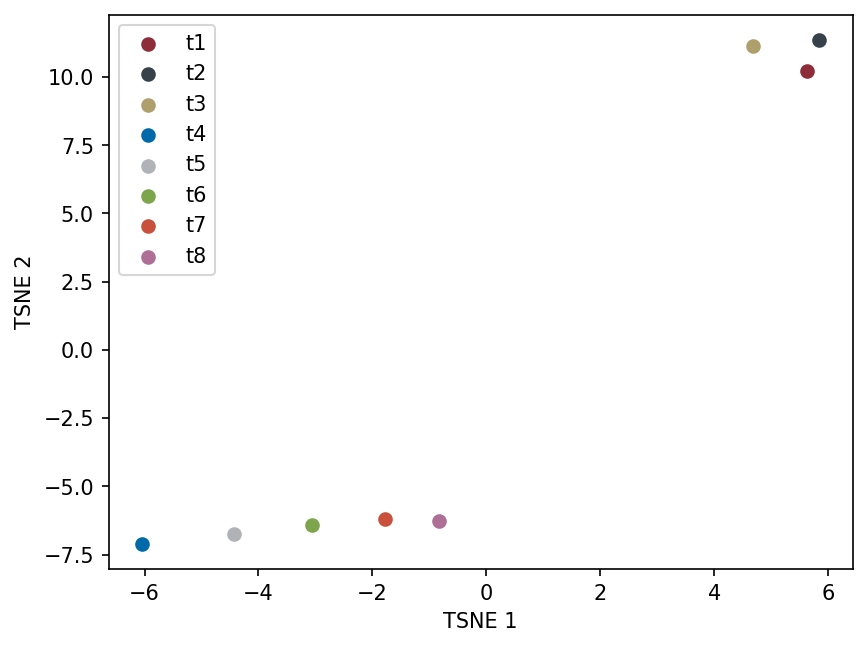

In [9]:
from matplotlib import colors

#cmap = plt.get_cmap('tab10')
#norm = colors.Normalize(vmin=0, vmax=len(labels_unique)-1)
#color_mapping = {label: cmap(norm(i)) for i, label in enumerate(labels_unique)}

cmap = palettes.tue_plot
color_mapping = {label: cmap[i] for i, label in enumerate(labels_unique)}


f = plt.figure()
for i in labels_unique:
  inds = [j == i for j in labels]
  scatter = plt.scatter(Y_star[inds, 0], Y_star[inds, 1], c = color_mapping[i], label=i)
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
#plt.legend(handles=scatter.legend_elements(num=8)[0], labels=labels)
plt.legend()
plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/tsne_embedding_M1152.pdf')



In [10]:
sensitivities = compute_sensitivities(X_flat, Y_flat, X_unflattener, Y_unflattener, 2.33)
np.save('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/sensitivities_M1152.npy', sensitivities)

In [11]:
sensitivities.shape

(16, 3168)

<Figure size 960x720 with 0 Axes>

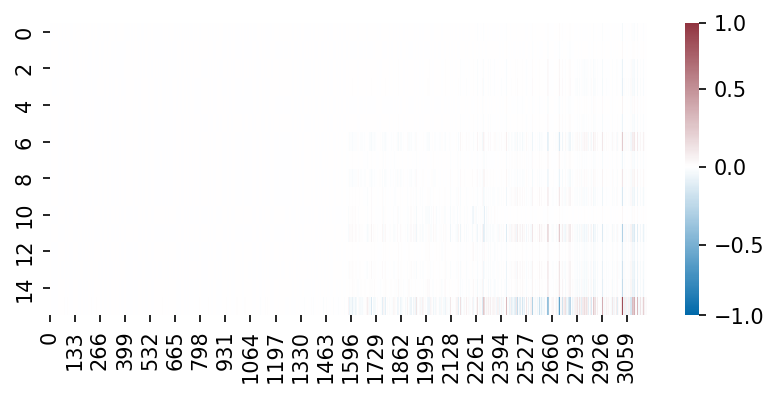

In [12]:
#import tikzplotlib
f = plt.figure()
px = 1/plt.rcParams['figure.dpi']
cm = 1/2.54
plot_heatmap(sensitivities, figsize=(14*cm, 7*cm), with_cell_lines=False)
plt.tight_layout()
plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/sensitivities_M1152.pdf')
#tikzplotlib.save("sensitivities.pgf")

### tnse1 coordinate of sample 5

Text(0, 0.5, 'variance')

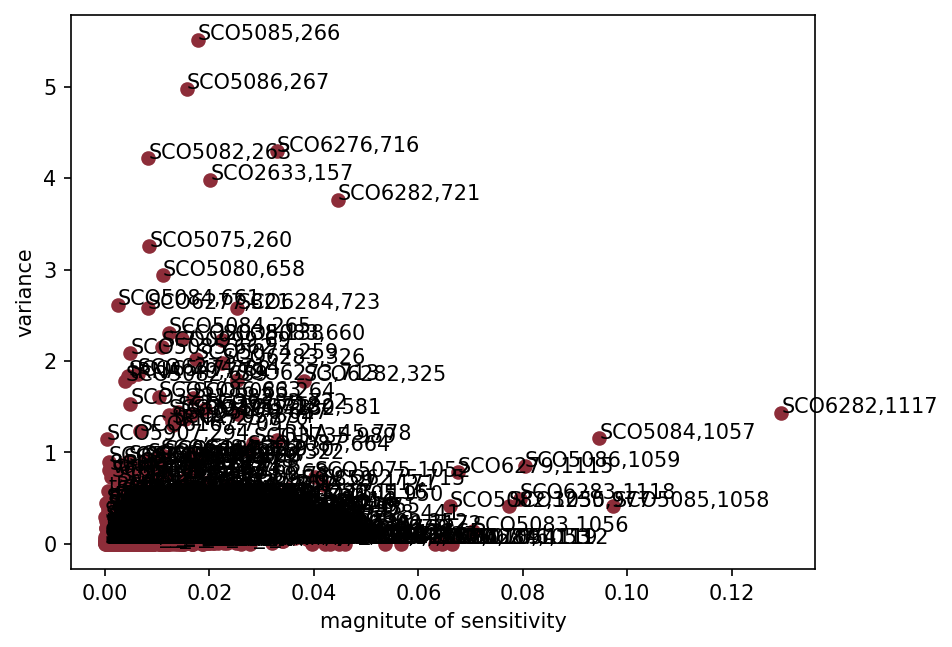

In [13]:
sens_subset = sensitivities[8, 1584:2772]
vars_subset  = flatten_vars[1584:2772]
gene_names_subset = np.array(np.repeat(X.columns, 3)).reshape(396, 3).flatten("F")
f = plt.figure()
plt.scatter(np.abs(sens_subset), vars_subset)
for i, txt in enumerate(gene_names_subset):
    plt.annotate(txt+','+str(i), (np.abs(sens_subset)[i], vars_subset[i]))
plt.xlabel('magnitute of sensitivity')
plt.ylabel('variance')

Text(0, 0.5, 'variance')

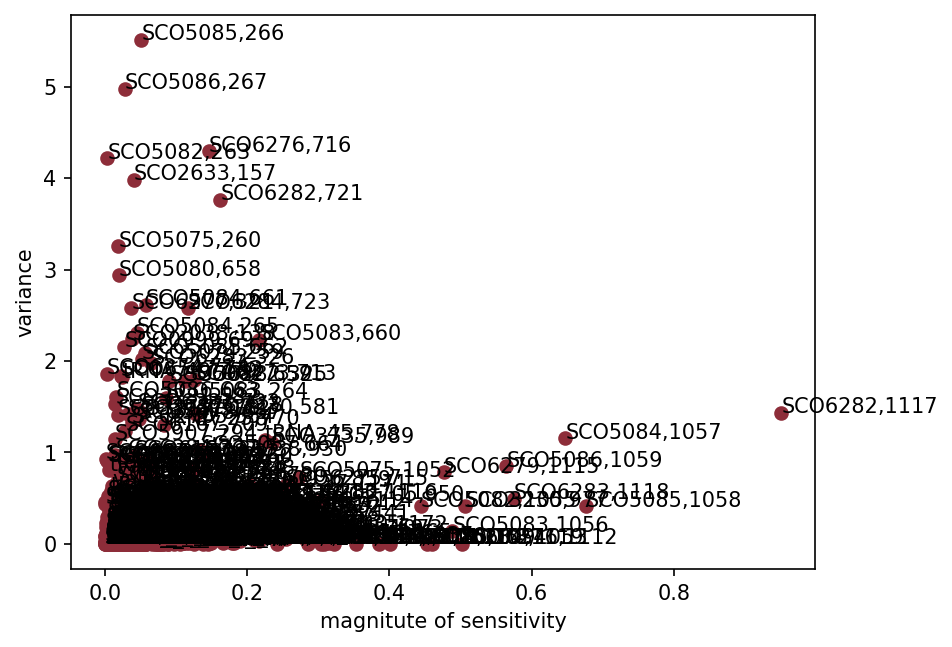

In [14]:
sens_subset = sensitivities[15, 1584:2772]
vars_subset  = flatten_vars[1584:2772]
gene_names_subset = np.array(np.repeat(X.columns, 3)).reshape(396, 3).flatten("F")
f = plt.figure()
plt.scatter(np.abs(sens_subset), vars_subset)
for i, txt in enumerate(gene_names_subset):
    plt.annotate(txt+','+str(i), (np.abs(sens_subset)[i], vars_subset[i]))
plt.xlabel('magnitute of sensitivity')
plt.ylabel('variance')

In [15]:
plot_matrix(sensitivities)

(0,0) [-0.0006631184] (1,0) [0.0010251361] (2,0) [0.0007581521] (3,0) [0.0004076735] (4,0) [-0.0034572883] (5,0) [0.0017679894] (6,0) [0.0014228807] (7,0) [-0.002122352] (8,0) [-0.000235032] (9,0) [0.0006830412] (10,0) [-0.0005200814] (11,0) [-0.00059662486] (12,0) [-0.0009451185] (13,0) [-0.0004699912] (14,0) [-0.0006732482] (15,0) [-6.629188e-05] (16,0) [-0.00058657565] (17,0) [-0.00049320643] (18,0) [0.0013379628] (19,0) [-0.00035998455] (20,0) [6.819557e-05] (21,0) [-0.00049742137] (22,0) [-0.00024045534] (23,0) [-0.00026466727] (24,0) [-0.00022323799] (25,0) [-0.00015378886] (26,0) [-0.000309036] (27,0) [-0.00011597888] (28,0) [2.6198686e-05] (29,0) [-0.00053774385] (30,0) [0.0011284928] (31,0) [0.00077408075] (32,0) [-0.00015666164] (33,0) [-0.0009107526] (34,0) [-0.00074350904] (35,0) [-0.00057733164] (36,0) [-0.0007005792] (37,0) [-0.0005961849] (38,0) [-0.000526739] (39,0) [-0.00040918385] (40,0) [-0.000654147] (41,0) [-0.0008083186] (42,0) [-0.0001592595] (43,0) [-0.000618182

<Figure size 960x720 with 0 Axes>

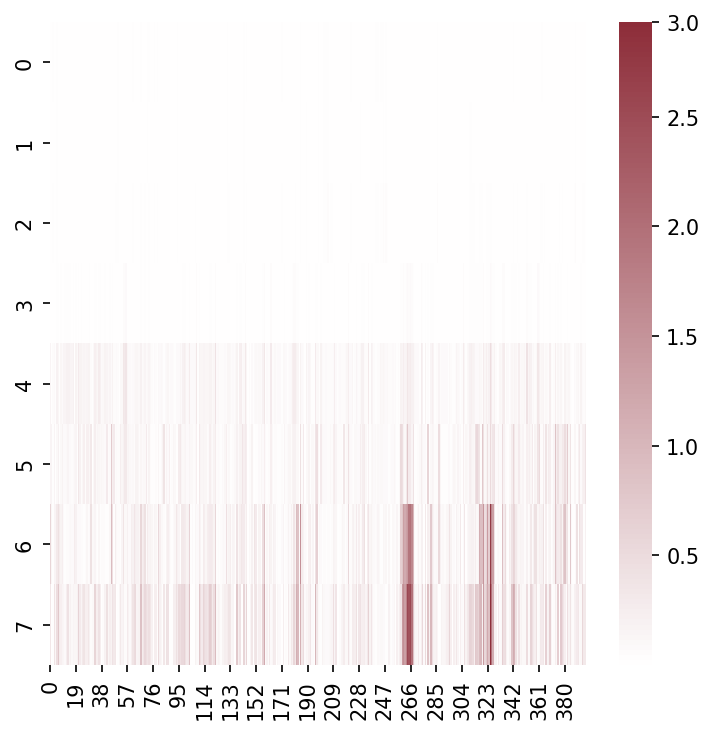

In [16]:
dy_dx_per_input = np.sum(np.abs(sensitivities), axis=0)
f = plt.figure()
#plt.plot(np.sum(np.abs(dy_dx), axis=0))
dy_dx_per_input_reshaped = X_unflattener(dy_dx_per_input) + 1e-8
plot_heatmap(dy_dx_per_input_reshaped, with_cell_lines=False)
np.save('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/sensitivities_summarized_M1152.npy', dy_dx_per_input_reshaped)
plt.tight_layout()
plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/sensitivities_summarized_M1152.pdf')

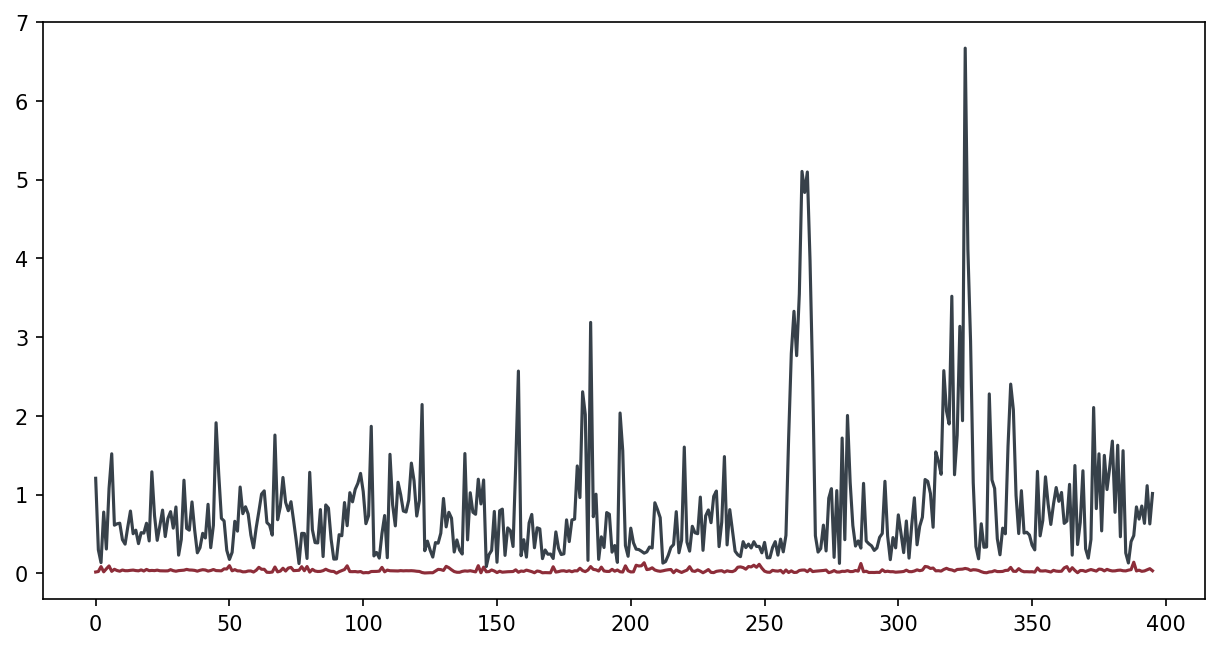

In [17]:
f = plt.figure(figsize=(10, 5))
dy_dx_per_input_group_t1_to_t3 = dy_dx_per_input_reshaped[0:3]
dy_dx_per_input_group_t4_to_t8 = dy_dx_per_input_reshaped[4:]
plt.plot(np.sum(dy_dx_per_input_group_t1_to_t3, axis=0))
plt.plot(np.sum(dy_dx_per_input_group_t4_to_t8, axis=0))

In M1152, the following gene clusters were deleted: actinorhodin, prodiginine, CPK adn CDA biosynthesis.
Furhtermore, point mutations are introduced to rpoB and rpsL (to increase secondary metabolite production).

388
325


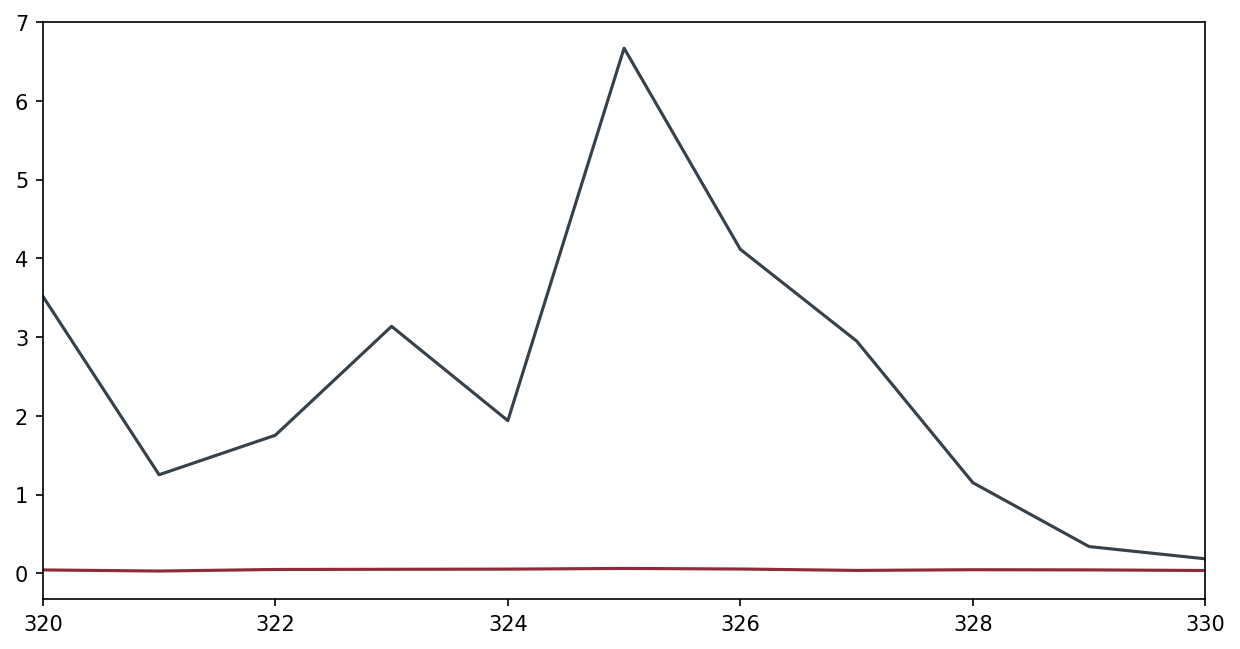

In [18]:
dy_dx_per_input_group_t1_to_t3 = dy_dx_per_input_reshaped[0:3]
dy_dx_per_input_group_t4_to_t8 = dy_dx_per_input_reshaped[4:]
f = plt.figure(figsize=(10, 5))
plt.plot(np.sum(dy_dx_per_input_group_t1_to_t3, axis=0))
plt.plot(np.sum(dy_dx_per_input_group_t4_to_t8, axis=0))
plt.xlim((320, 330))
print(np.argmax(np.sum(dy_dx_per_input_group_t1_to_t3, axis=0)))
print(np.argmax(np.sum(dy_dx_per_input_group_t4_to_t8, axis=0)))

In [19]:
print(X.columns[325])

SCO6282


SCO6282/CAC37883 is a putative 3-oxoacyl-[acyl-carrier protein] reductase. CAC37883: putative 3-oxoacyl-[acyl-carrier protein] reductase, SCO6282, part of the biosynthesis of a cryptic polyketide (gene cluster SCO6273-6288) in S. coelicolor (https://link.springer.com/article/10.1007/s00253-007-1184-5), Nicotinamide-dependent dehydrogenase, which is part of the coelimycin P1 biosynthetic gene cluster (https://mibig.secondarymetabolites.org/repository/BGC0000038.5/index.html#r1c1); coelimycin P1, an unusual yellow-pigmented metabolic product of the cpk cryptic polyketide biosynthetic gene cluster (https://pubs.rsc.org/en/content/articlelanding/2012/sc/c2sc20410j)

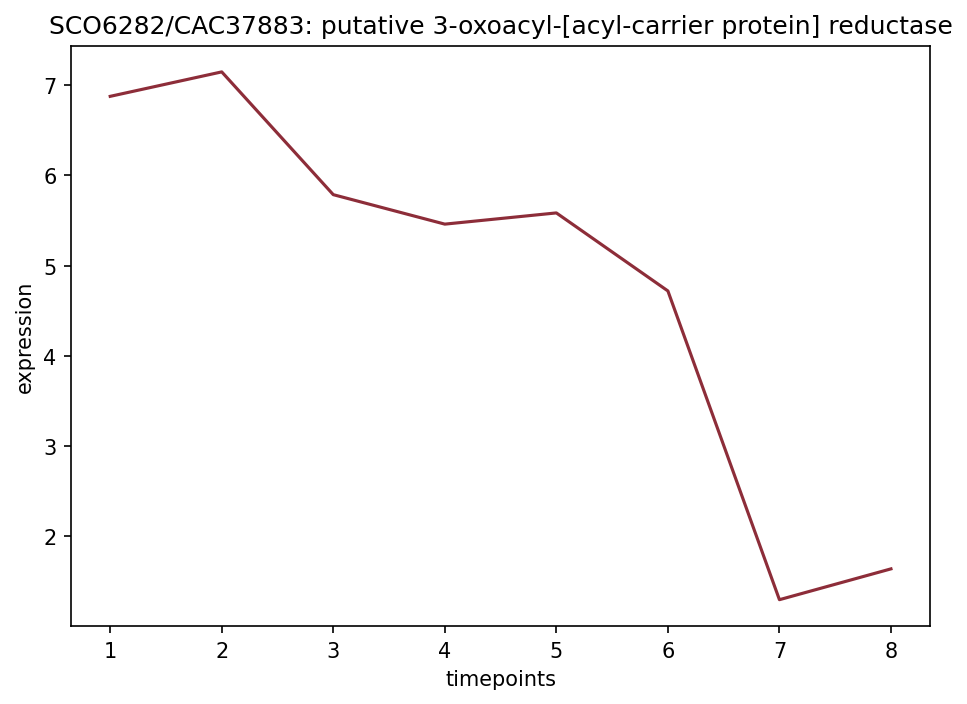

In [20]:
for i in range(325, 326):
  plt.plot(np.arange(1, 9), X.values[:, i])
  plt.xlabel('timepoints')
  plt.ylabel('expression')
  plt.title('SCO6282/CAC37883: putative 3-oxoacyl-[acyl-carrier protein] reductase')
  plt.tight_layout()
  plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/SCO6282.pdf')

388
325


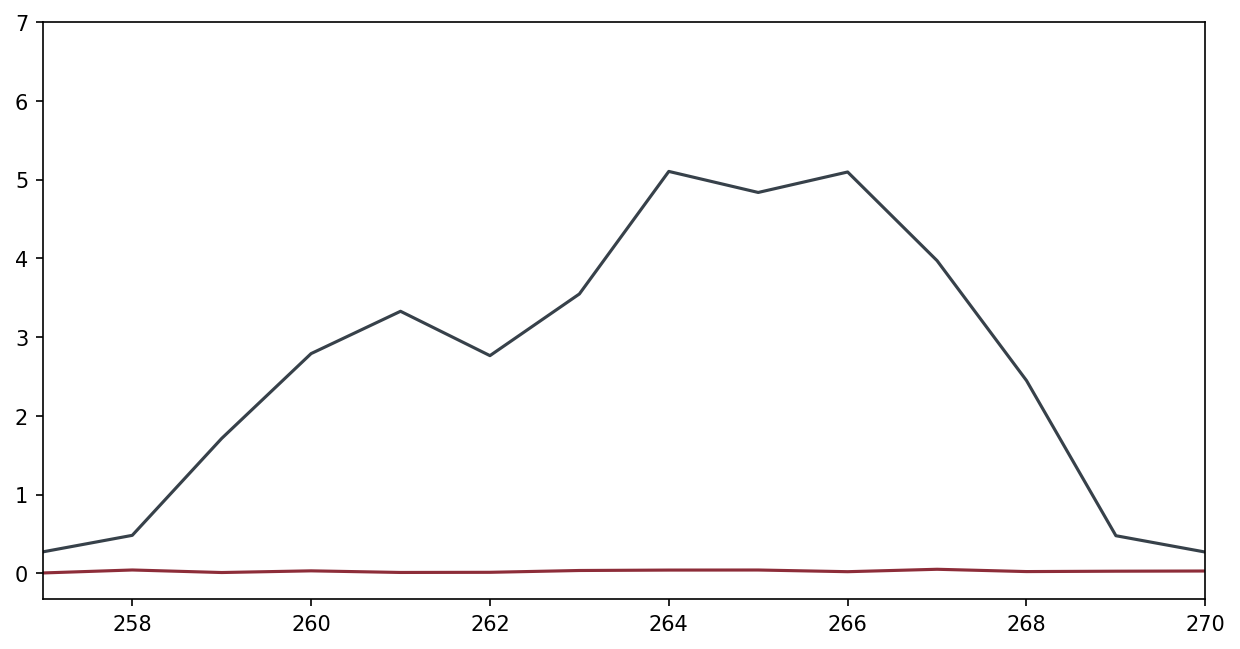

In [21]:
dy_dx_per_input_group_t1_to_t3 = dy_dx_per_input_reshaped[0:3]
dy_dx_per_input_group_t4_to_t8 = dy_dx_per_input_reshaped[4:]
f = plt.figure(figsize=(10, 5))
plt.plot(np.sum(dy_dx_per_input_group_t1_to_t3, axis=0))
plt.plot(np.sum(dy_dx_per_input_group_t4_to_t8, axis=0))
plt.xlim((257, 270))
print(np.argmax(np.sum(dy_dx_per_input_group_t1_to_t3, axis=0)))
print(np.argmax(np.sum(dy_dx_per_input_group_t4_to_t8, axis=0)))

In [22]:
print(X.columns[range(264, 267)])

Index(['SCO5083', 'SCO5084', 'SCO5085'], dtype='object', name='Identifier')


SCO5085/CAC44198 is the actinorhodin cluster activator protein from the actinorhodin BGC.
The ActII-2 and ActII-3 proteins (SCO5083 and SCO5084) mediate actinorhodin transport.

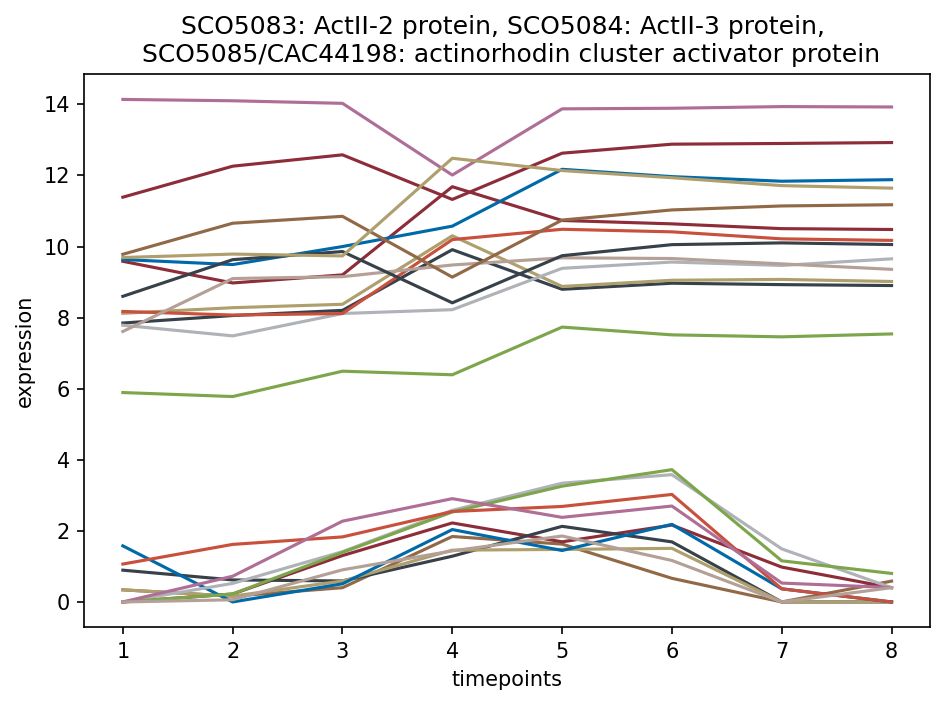

In [ ]:
for i in range(264, 267):
#for i in range(250, 273):
  plt.plot(np.arange(1,9), X.values[:, i])
  plt.xlabel('timepoints')
  plt.ylabel('expression')
  plt.title('SCO5083: ActII-2 protein, SCO5084: ActII-3 protein, \n SCO5085/CAC44198: actinorhodin cluster activator protein')
  plt.tight_layout()
  plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/SCO5083-SCO5085.pdf')

In [22]:
cov_final = compute_cov_without_kronecker(X_flat, Y_flat, X_unflattener, Y_unflattener, input_cov, 2.33)
cov_final = cov_final + 1e-3*np.eye(len(cov_final))

<Axes: >

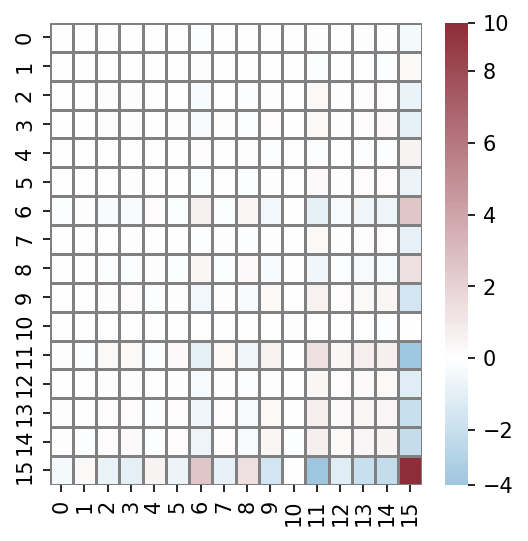

In [45]:
plot_heatmap(cov_final, figsize=(4, 4))

(16, 15)


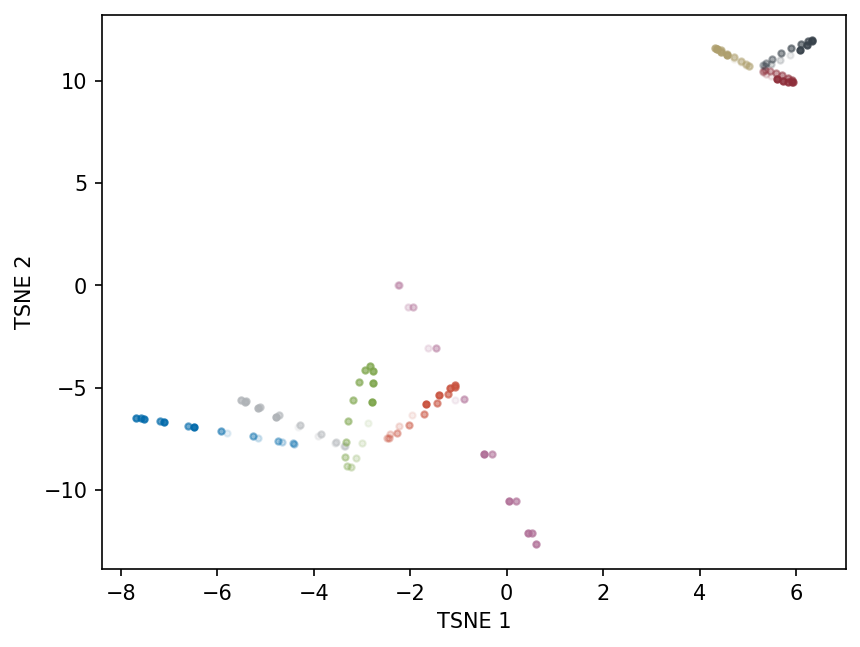

In [55]:
from utils import equipotential_standard_normal

n_samples = 15
y_int = [i for i in range(Y_star.shape[0])]
S = equipotential_standard_normal(2 * Y_star.shape[0], n_samples)
L, lower = jax.scipy.linalg.cho_factor(cov_final, lower=True)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_flat)
print(samples.shape)

fig = plt.figure(1)
for j, sample in enumerate(samples.T):
    sample = Y_unflattener(sample)
    for i, s in enumerate(sample): 
        plt.plot(s[0], s[1], c=palettes.tue_plot[i], alpha=[i for i in np.arange(0.1, 1, 1/(n_samples+2))][j], marker='.')
               #marker=list(Line2D.markers.keys())[j])
#plt.axis('equal')
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/animation_static_M1152.pdf')

In [51]:
from utils import equipotential_standard_normal_within_one_std, equipotential_standard_normal

S = equipotential_standard_normal(2 * Y_star.shape[0], 20)
L, lower = jax.scipy.linalg.cho_factor(cov_final + 1e-5*np.identity(cov_final.shape[0]), lower=True)
samples = np.transpose(np.transpose(np.dot(L, S))+Y_flat)

In [26]:
np.save('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/M1152_samples_for_animation.npy', samples)

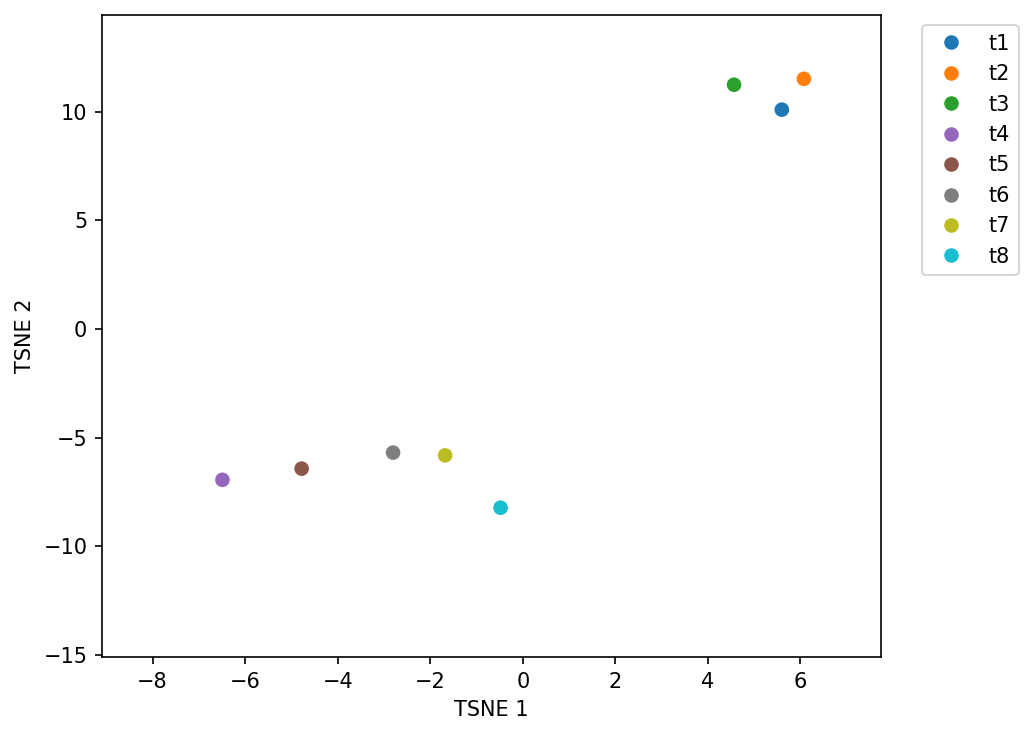

In [56]:
from animate_ifd import *
animate(samples, labels, '/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/animation_M1152.gif', cmap='tab10')

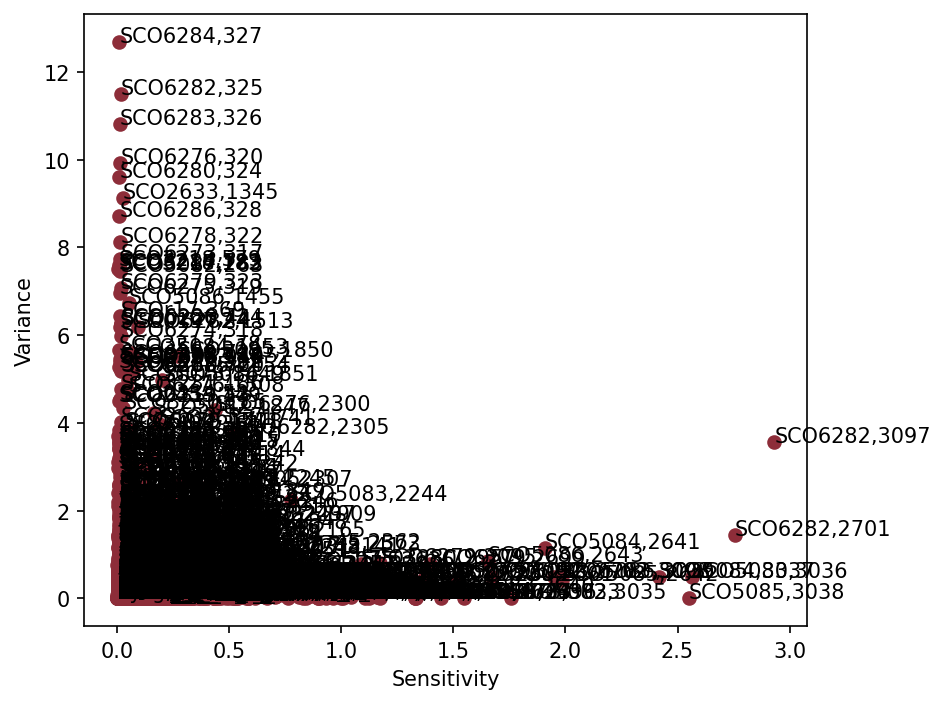

In [59]:
plt.scatter(dy_dx_per_input, flatten_vars)
gene_names_subset = np.array(np.repeat(X.columns, 8)).reshape(396, 8).flatten("F")
for i, txt in enumerate(gene_names_subset):
    plt.annotate(txt+','+str(i), (dy_dx_per_input[i], flatten_vars[i]))
    plt.xlabel('Sensitivity')
    plt.ylabel('Variance')
plt.tight_layout()
plt.savefig('/ceph/ibmi/it/users/zabel/tsne/diss/datasets/Scoelicolor/results/sens_var_M1152.pdf')

In [37]:
2305/396

5.820707070707071

In [38]:
325+5*396

2305